In [1]:
import os
import sys
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
# from tqdm.rich import tqdm
from tqdm import tqdm
import h5py

import seaborn as sns
import matplotlib.pylab as plt
sys.path.append("..") 
from emd import emd_pot
from data import get_database_path, get_h5_files, read_h5_file
np.random.seed(114514)

In [2]:
def sample_pairs(n_events, n_pairs):
    # np.random.choice can be extremely slow, use randint instead
    pairs = np.random.randint(0, n_events, (n_pairs, 2))
    # remove pairs with same index since we don't want to compare the same event
    bad_samples_idx = np.where(pairs[:, 0] == pairs[:, 1])
    for i in bad_samples_idx:
        pairs[i] = np.random.choice(n_events, 2, replace=False)
    return pairs

def sample_matrix(n_events, pairs):
    matrix = np.zeros((n_events, n_events))
    for pair in pairs:
        matrix[pair[0], pair[1]] += 1
    return matrix

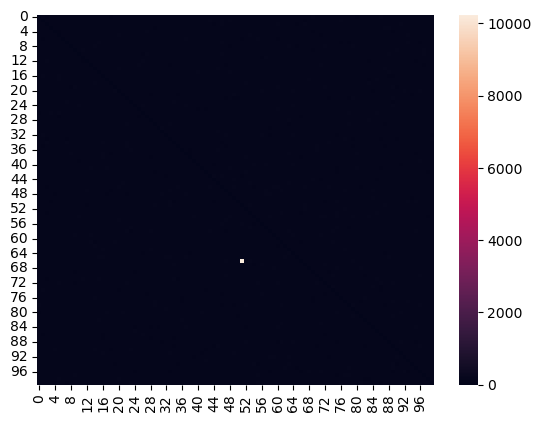

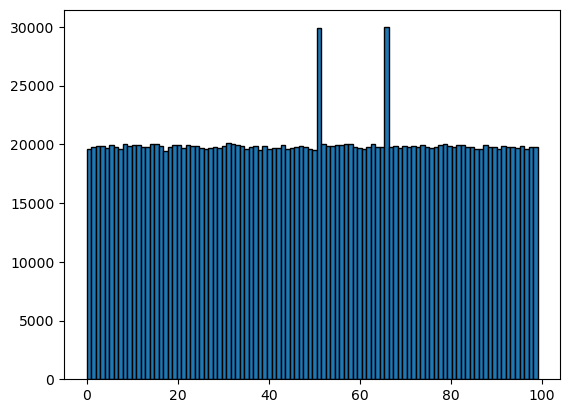

In [3]:
test_n_events = 100
test_n_pairs = 1000000
test_pairs = sample_pairs(test_n_events, test_n_pairs)
test_matrix = sample_matrix(test_n_events, test_pairs)
ax = sns.heatmap(test_matrix)
plt.show()
plt.hist(test_pairs.flatten(), bins=test_n_events, edgecolor='black')
plt.show()

In [4]:
def sample_pairs_with_emd(events, n_pairs=None):
    n_events = len(events)
    if n_pairs is None:
        n_pairs = 5 * n_events
    pairs = sample_pairs(n_events, n_pairs)
    emds = np.zeros(n_pairs)
    for i, pair in enumerate(tqdm(pairs)):
        emds[i] = emd_pot(events[pair[0]], events[pair[1]])
    return pairs, emds

def store_emds_with_pairs(emds, pairs, filename):
    f = h5py.File(os.path.join(get_database_path(), "generated_data", filename), "w")
    f["pairs"] = pairs
    f["emds"] = emds
    f.close()



In [5]:
database_path = get_database_path()
bkg_files, sig_files = get_h5_files()

bkg_types = [bkg_files[i]['type'] for i in range(len(bkg_files))]
sig_types = [sig_files[i]['type'] for i in range(len(sig_files))]
print(bkg_types)
print(sig_types)

['SM']
['A->4_leptons', 'LQ_->b_tau', 'h^0->tau_tau', 'h+->tau_nu']


In [6]:
bkg = read_h5_file(database_path, bkg_files[0]['file'])
# SM processes

neutral_boson = read_h5_file(database_path, sig_files[0]['file'])
# A neutral scalar boson (A) with mass 50 GeV, decaying to two off-shell Z bosons, each forced to decay to two leptons: A → 4l

leptoquark = read_h5_file(database_path, sig_files[1]['file'])
# A leptoquark (LQ) with mass 80 GeV, decaying to a b quark and a τ lepton24

neutral_higgs = read_h5_file(database_path, sig_files[2]['file'])
# A scalar boson with mass 60 GeV, decaying to two tau leptons: h0→ ττ

charged_higgs = read_h5_file(database_path, sig_files[3]['file'])
# A charged scalar boson with mass 60 GeV, decaying to a tau lepton and a neutrino


In [7]:
bkg_pairs, bkg_emds = sample_pairs_with_emd(bkg)
store_emds_with_pairs(bkg_emds, bkg_pairs, "bkg_emds.h5")

neutral_boson_pairs, neutral_boson_emds = sample_pairs_with_emd(neutral_boson)
store_emds_with_pairs(neutral_boson_emds, neutral_boson_pairs, "neutral_boson_emds.h5")

leptoquark_pairs, leptoquark_emds = sample_pairs_with_emd(leptoquark)
store_emds_with_pairs(leptoquark_emds, leptoquark_pairs, "leptoquark_emds.h5")

neutral_higgs_pairs, neutral_higgs_emds = sample_pairs_with_emd(neutral_higgs)
store_emds_with_pairs(neutral_higgs_emds, neutral_higgs_pairs, "neutral_higgs_emds.h5")

charged_higgs_pairs, charged_higgs_emds = sample_pairs_with_emd(charged_higgs)
store_emds_with_pairs(charged_higgs_emds, charged_higgs_pairs, "charged_higgs_emds.h5")

100%|██████████| 3801360/3801360 [01:45<00:00, 35907.00it/s]


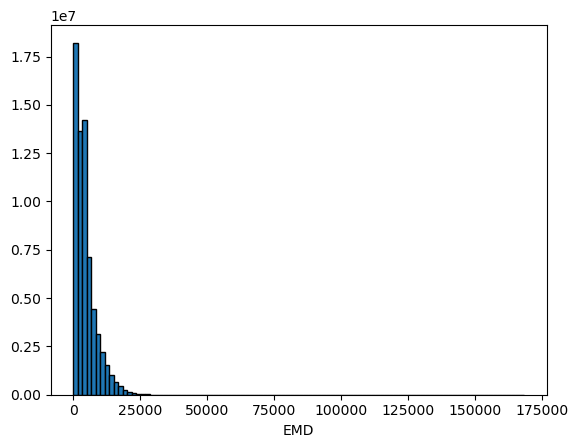

In [8]:
plt.hist(bkg_emds, bins=100,edgecolor='black')
plt.xlabel("EMD")
plt.show()

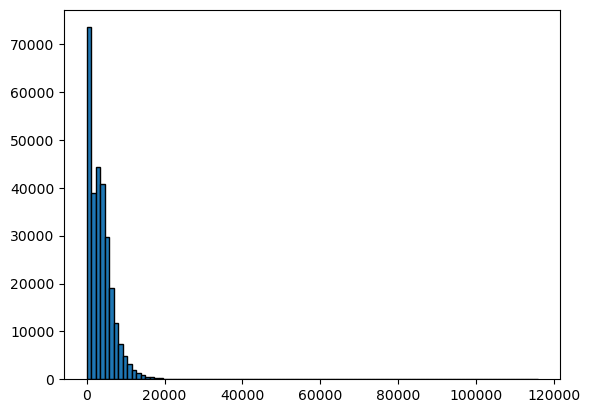

In [9]:
plt.hist(neutral_boson_emds, bins=100,edgecolor='black')
plt.show()

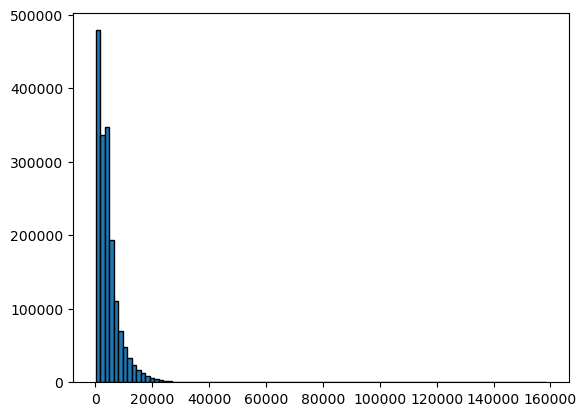

In [10]:
plt.hist(leptoquark_emds, bins=100,edgecolor='black')
plt.show()

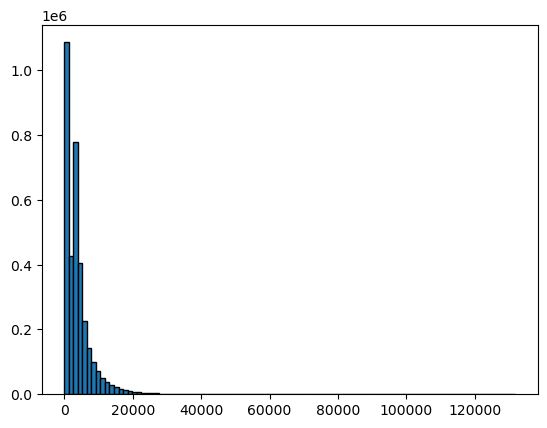

In [11]:
plt.hist(neutral_higgs_emds, bins=100,edgecolor='black')
plt.show()

In [12]:
class PairedEventsDataset(Dataset):
    def __init__(self, events, pairs, emds):
        assert len(emds) == len(pairs)
        assert len(pairs.shape) == 2 and pairs.shape[1] == 2
        self.events = torch.from_numpy(events)
        self.pairs = torch.from_numpy(pairs)
        self.emds = torch.from_numpy(emds)
        
    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.events[self.pairs[idx][0]], self.events[self.pairs[idx][1]], self.emds[idx]
        

In [13]:
bkg_pairs, bkg_emds = read_h5_file(database_path, "bkg_emds.h5", datatype='EMD')

In [19]:
print(bkg_pairs.shape)
print(bkg_emds.shape)

(67259575, 2)
(67259575,)


In [20]:
bkg_dataset = PairedEventsDataset(bkg, bkg_pairs, bkg_emds)